In [ ]:
import gdown
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import datetime as dt
from sklearn.preprocessing import StandardScaler

In [ ]:
def download_geospatial_data():
  mobility_id = "14qJUkCnpWjw73gI08gSybGkWu_XuTC4Q"
  mobility_url = f'https://drive.google.com/uc?id={mobility_id}&export=download'
  mobility_file = "Mobility.zip"
  gdown.download(mobility_url, mobility_file, quiet=True)
  mobility = gpd.read_file(mobility_file)

  return{"mobility": mobility}

In [ ]:
data = download_geospatial_data()
mobility_df = data["mobility"]

In [ ]:
!unzip "Mobility.zip"

Archive:  Mobility.zip
 extracting: Baltimore_2018_01.csv   
 extracting: Baltimore_2018_02.csv   
 extracting: Baltimore_2018_03.csv   
 extracting: Baltimore_2018_04.csv   
 extracting: Baltimore_2018_05.csv   
 extracting: Baltimore_2018_06.csv   
 extracting: Baltimore_2018_07.csv   
 extracting: Baltimore_2018_08.csv   
 extracting: Baltimore_2018_09.csv   
 extracting: Baltimore_2018_10.csv   
 extracting: Baltimore_2018_11.csv   
 extracting: Baltimore_2018_12.csv   
 extracting: Baltimore_2019_01.csv   
 extracting: Baltimore_2019_02.csv   
 extracting: Baltimore_2019_03.csv   
 extracting: Baltimore_2019_04.csv   
 extracting: Baltimore_2019_05.csv   
 extracting: Baltimore_2019_06.csv   
 extracting: Baltimore_2019_07.csv   
 extracting: Baltimore_2019_08.csv   
 extracting: Baltimore_2019_09.csv   
 extracting: Baltimore_2019_10.csv   
 extracting: Baltimore_2019_11.csv   
 extracting: Baltimore_2019_12.csv   
 extracting: Baltimore_2020_01.csv   
 extracting: Baltimore_2020

In [ ]:
crime_id = "1BrYiU8Y7l9WwPPDUdrahendeDAInbAhV"
crime_url = f'https://drive.google.com/uc?id={crime_id}&export=download'
crime_file = "Cleaned_Crime_Data1.xlsx"
gdown.download(crime_url, crime_file, quiet=True)
crime_df_original = pd.read_excel(crime_file, dtype={"Post": "string", "Ethnicity": "string"})

In [ ]:
file_names = [file for file in os.listdir() if "Baltimore" in file]

In [ ]:
file_names

['Baltimore_2018_10.csv',
 'Baltimore_2018_02.csv',
 'Baltimore_2022_11.csv',
 'Baltimore_2019_12.csv',
 'Baltimore_2020_03.csv',
 'Baltimore_2018_07.csv',
 'Baltimore_2022_01.csv',
 'Baltimore_2020_04.csv',
 'Baltimore_2018_03.csv',
 'Baltimore_2022_04.csv',
 'Baltimore_2022_03.csv',
 'Baltimore_2021_03.csv',
 'Baltimore_2019_05.csv',
 'Baltimore_2020_02.csv',
 'Baltimore_2019_02.csv',
 'Baltimore_2019_10.csv',
 'Baltimore_2021_05.csv',
 'Baltimore_2020_10.csv',
 'Baltimore_2018_01.csv',
 'Baltimore_2021_09.csv',
 'Baltimore_2020_05.csv',
 'Baltimore_2022_02.csv',
 'Baltimore_2019_09.csv',
 'Baltimore_2020_11.csv',
 'Baltimore_2018_09.csv',
 'Baltimore_2018_08.csv',
 'Baltimore_2021_11.csv',
 'Baltimore_2020_08.csv',
 'Baltimore_2019_08.csv',
 'Baltimore_2018_05.csv',
 'Baltimore_2022_08.csv',
 'Baltimore_2020_09.csv',
 'Baltimore_2019_11.csv',
 'Baltimore_2022_12.csv',
 'Baltimore_2018_04.csv',
 'Baltimore_2021_04.csv',
 'Baltimore_2020_07.csv',
 'Baltimore_2021_01.csv',
 'Baltimore_

In [ ]:
storage = pd.DataFrame()
for file in file_names:
  csv_df = pd.read_csv(file)
  csv_df["Year Month"]=file.split("Baltimore_")[1].replace(".csv","")
  storage = pd.concat([storage,csv_df],ignore_index=True)

In [ ]:
raw_visit_counts = storage.groupby(by="Year Month").sum(numeric_only=True)[["raw_visit_counts"]].reset_index()
raw_visit_counts_filtered = raw_visit_counts

In [ ]:
crime_df_all = crime_df_original.copy()

In [ ]:
crime_df_all["Year and Month"]=crime_df_all["CrimeDateTime"].astype(str).str.slice(0,7)

In [ ]:
crime_df = crime_df_all[crime_df_all['Description'] == 'AGG. ASSAULT']
#crime_df = crime_df_all

In [ ]:
crime_counts = crime_df.groupby(by="Year and Month").size().reset_index(name='Crime Count')
crime_counts_filtered = crime_counts[crime_counts['Year and Month'].str.startswith(('2018', '2019', '2020', '2021', '2022'))]
crime_counts_filtered_sorted = crime_counts_filtered.sort_values(by='Year and Month')

In [ ]:
x_raw_visit_counts = raw_visit_counts["raw_visit_counts"]
y_crime_counts = crime_counts_filtered_sorted["Crime Count"]

In [ ]:
X = np.asarray(list(zip(x_raw_visit_counts,y_crime_counts)))

In [ ]:
k_means = KMeans(n_clusters = 2, random_state=0).fit(X)
label = k_means.labels_
k_means_df = pd.DataFrame(X)
k_means_df.columns = ["Raw Visits", "Crime Count"]
k_means_df['Cluster'] = label
k_means_df['Date'] = crime_counts_filtered_sorted['Year and Month'].values
k_means_df['COVID'] = pd.to_datetime(k_means_df['Date']) <= pd.to_datetime("2020-03-01")
k_means_df['COVID'] = k_means_df['COVID'].replace(True,"Pre").replace(False,"Post")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-19-0e2700c65cb9>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  k_means_df['COVID'] = pd.to_datetime(k_means_df['Date']) <= pd.to_datetime("2020-03-01")


In [ ]:
# Create a contingency table
contingency_table = pd.crosstab(k_means_df['Cluster'], k_means_df['COVID'])

# Rename the index and columns
contingency_table.index = ['c0', 'c1']
contingency_table.columns = ['Post', 'Pre']

print(contingency_table)

    Post  Pre
c0    33    3
c1     0   24


In [ ]:
from scipy.stats import chi2_contingency

# Perform the chi-squared test for independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-squared test statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)

Chi-squared test statistic: 45.25533108866442
P-value: 1.729491139529757e-11
Degrees of Freedom: 1


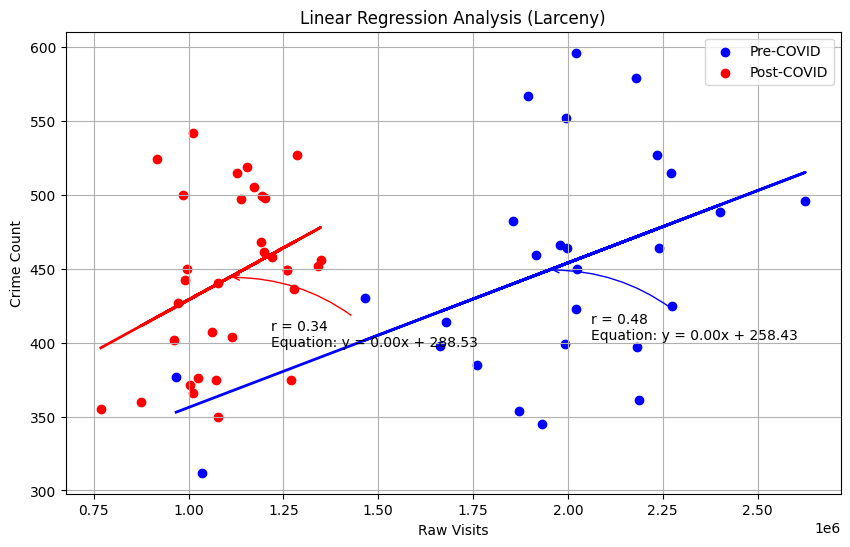

Correlation coefficient (r) for Pre-COVID cluster: 0.47773769350079487
Correlation coefficient (r) for Post-COVID cluster: 0.3430204393035727


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Plot linear regression lines for Pre and Post separately with points
plt.figure(figsize=(10, 6))

# Filter data for Pre-COVID
pre_covid_data = k_means_df[k_means_df['COVID'] == 'Pre']
X_pre = pre_covid_data[['Raw Visits']]
y_pre = pre_covid_data['Crime Count']

# Fit linear regression model for Pre-COVID
reg_pre = LinearRegression().fit(X_pre, y_pre)

# Predict y values for Pre-COVID
y_pred_pre = reg_pre.predict(X_pre)

# Plot points and regression line for Pre-COVID
plt.scatter(X_pre, y_pre, color='blue', label='Pre-COVID')
plt.plot(X_pre, y_pred_pre, color='blue', linestyle='-', linewidth=2)

# Calculate correlation coefficient for Pre-COVID
r_pre = np.corrcoef(X_pre.squeeze(), y_pre)[0, 1]
plt.annotate(f'r = {r_pre:.2f}\nEquation: y = {reg_pre.coef_[0]:.2f}x + {reg_pre.intercept_:.2f}',
             xy=(np.mean(X_pre), np.mean(y_pre)), xycoords='data',
             xytext=(30, -50), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", color='blue', connectionstyle="arc3,rad=.2"))

# Filter data for Post-COVID
post_covid_data = k_means_df[k_means_df['COVID'] == 'Post']
X_post = post_covid_data[['Raw Visits']]
y_post = post_covid_data['Crime Count']

# Fit linear regression model for Post-COVID
reg_post = LinearRegression().fit(X_post, y_post)

# Predict y values for Post-COVID
y_pred_post = reg_post.predict(X_post)

# Plot points and regression line for Post-COVID
plt.scatter(X_post, y_post, color='red', label='Post-COVID')
plt.plot(X_post, y_pred_post, color='red', linestyle='-', linewidth=2)

# Calculate correlation coefficient for Post-COVID
r_post = np.corrcoef(X_post.squeeze(), y_post)[0, 1]
plt.annotate(f'r = {r_post:.2f}\nEquation: y = {reg_post.coef_[0]:.2f}x + {reg_post.intercept_:.2f}',
             xy=(np.mean(X_post), np.mean(y_post)), xycoords='data',
             xytext=(30, -50), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", color='red', connectionstyle="arc3,rad=.2"))

plt.title('Linear Regression Analysis (Larceny)')
plt.xlabel('Raw Visits')
plt.ylabel('Crime Count')
plt.legend()
plt.grid(True)
plt.show()

print("Correlation coefficient (r) for Pre-COVID cluster:", r_pre)
print("Correlation coefficient (r) for Post-COVID cluster:", r_post)

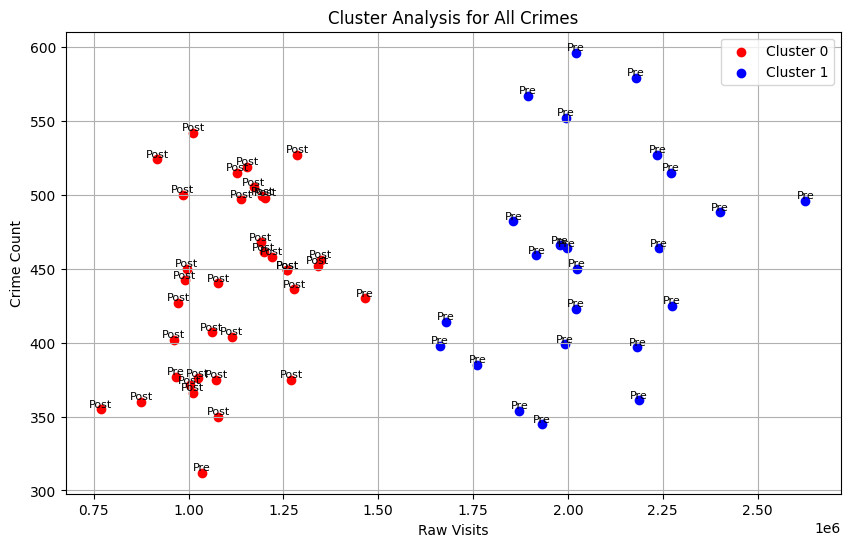

In [ ]:
# Plot the clusters with labels for pre and post-COVID
plt.figure(figsize=(10, 6))

# Scatter plot for Cluster 0
plt.scatter(k_means_df[k_means_df['Cluster'] == 0]['Raw Visits'],
            k_means_df[k_means_df['Cluster'] == 0]['Crime Count'],
            color='red', label='Cluster 0')

# Scatter plot for Cluster 1
plt.scatter(k_means_df[k_means_df['Cluster'] == 1]['Raw Visits'],
            k_means_df[k_means_df['Cluster'] == 1]['Crime Count'],
            color='blue', label='Cluster 1')

# Add labels for pre and post-COVID
for i in range(len(k_means_df)):
    plt.text(k_means_df.iloc[i]['Raw Visits'],
             k_means_df.iloc[i]['Crime Count'],
             k_means_df.iloc[i]['COVID'],
             fontsize=8, ha='center', va='bottom')

plt.title('Cluster Analysis for All Crimes')
plt.xlabel('Raw Visits')
plt.ylabel('Crime Count')
plt.legend()
plt.grid(True)
plt.show()

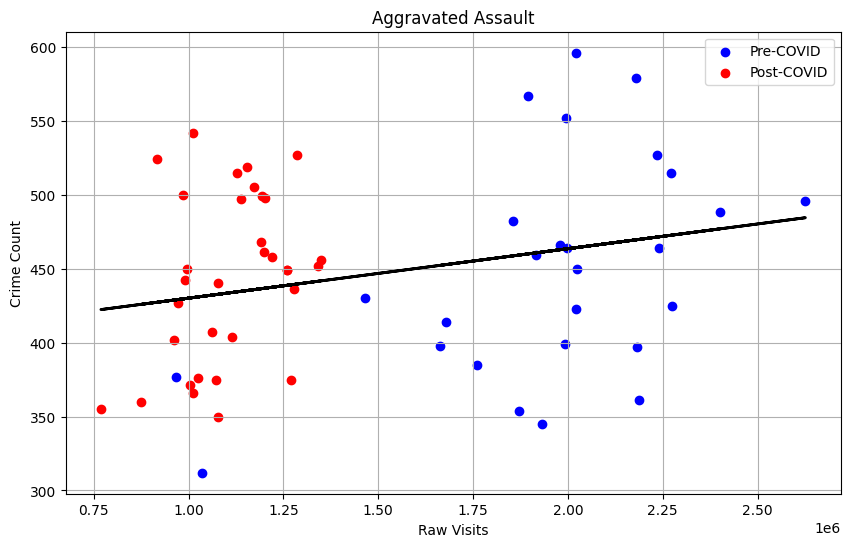

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pandas as pd

plt.figure(figsize=(10, 6))

# Filter data for Pre-COVID
pre_covid_data = k_means_df[k_means_df['COVID'] == 'Pre']
X_pre = pre_covid_data[['Raw Visits']]
y_pre = pre_covid_data['Crime Count']
plt.scatter(X_pre, y_pre, color='blue', label='Pre-COVID')

# Filter data for Post-COVID
post_covid_data = k_means_df[k_means_df['COVID'] == 'Post']
X_post = post_covid_data[['Raw Visits']]
y_post = post_covid_data['Crime Count']
plt.scatter(X_post, y_post, color='red', label='Post-COVID')

# Combine data for both Pre-COVID and Post-COVID
combined_data = pd.concat([pre_covid_data, post_covid_data])

# Extract features (X) and target variable (y)
X_combined = combined_data[['Raw Visits']]
y_combined = combined_data['Crime Count']

# Fit linear regression model for combined data
reg_combined = LinearRegression().fit(X_combined, y_combined)

# Predict y values for combined data
y_pred_combined = reg_combined.predict(X_combined)

# Plot regression line for combined data
plt.plot(X_combined, y_pred_combined, color='black', linestyle='-', linewidth=2)

plt.title('Aggravated Assault')
plt.xlabel('Raw Visits')
plt.ylabel('Crime Count')
plt.legend()
plt.grid(True)
plt.show()

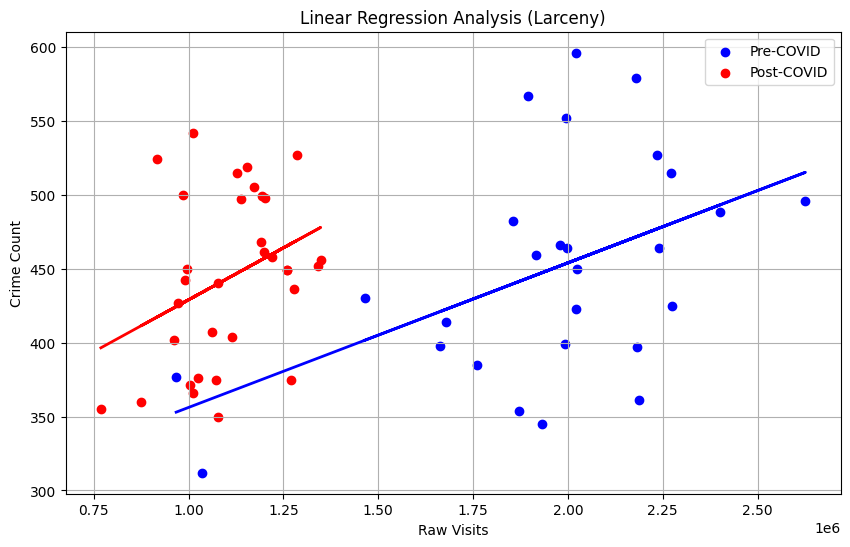

R-squared value for Pre-COVID cluster: 0.22823330379145923
R-squared value for Post-COVID cluster: 0.11766302178001575


In [ ]:
# Plot linear regression lines for Pre and Post separately with points
plt.figure(figsize=(10, 6))

# Filter data for Pre-COVID
pre_covid_data = k_means_df[k_means_df['COVID'] == 'Pre']
X_pre = pre_covid_data[['Raw Visits']]
y_pre = pre_covid_data['Crime Count']

# Fit linear regression model for Pre-COVID
reg_pre = LinearRegression().fit(X_pre, y_pre)

# Predict y values for Pre-COVID
y_pred_pre = reg_pre.predict(X_pre)

# Plot points and regression line for Pre-COVID
plt.scatter(X_pre, y_pre, color='blue', label='Pre-COVID')
plt.plot(X_pre, y_pred_pre, color='blue', linestyle='-', linewidth=2)

# Filter data for Post-COVID
post_covid_data = k_means_df[k_means_df['COVID'] == 'Post']
X_post = post_covid_data[['Raw Visits']]
y_post = post_covid_data['Crime Count']

# Fit linear regression model for Post-COVID
reg_post = LinearRegression().fit(X_post, y_post)

# Predict y values for Post-COVID
y_pred_post = reg_post.predict(X_post)

# Plot points and regression line for Post-COVID
plt.scatter(X_post, y_post, color='red', label='Post-COVID')
plt.plot(X_post, y_pred_post, color='red', linestyle='-', linewidth=2)

plt.title('Linear Regression Analysis (Larceny)')
plt.xlabel('Raw Visits')
plt.ylabel('Crime Count')
plt.legend()
plt.grid(True)
plt.show()

# Calculate R-squared for Pre-COVID
r_squared_pre = reg_pre.score(X_pre, y_pre)
print("R-squared value for Pre-COVID cluster:", r_squared_pre)

# Calculate R-squared for Post-COVID
r_squared_post = reg_post.score(X_post, y_post)
print("R-squared value for Post-COVID cluster:", r_squared_post)

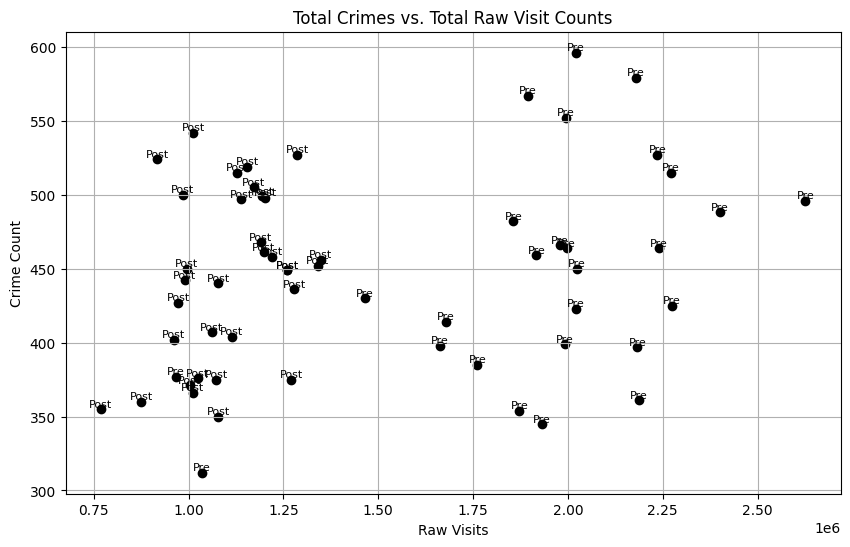

In [ ]:
# Plot without cluster analysis, labeling with words for Pre and Post-COVID
plt.figure(figsize=(10, 6))

# Plot data points for Pre-COVID
plt.scatter(k_means_df[k_means_df['COVID'] == 'Pre']['Raw Visits'],
            k_means_df[k_means_df['COVID'] == 'Pre']['Crime Count'],
            color='black', label='Pre-COVID')

# Plot data points for Post-COVID
plt.scatter(k_means_df[k_means_df['COVID'] == 'Post']['Raw Visits'],
            k_means_df[k_means_df['COVID'] == 'Post']['Crime Count'],
            color='black', label='Post-COVID')

# Label data points with words
for i in range(len(k_means_df)):
    plt.text(k_means_df.iloc[i]['Raw Visits'],
             k_means_df.iloc[i]['Crime Count'],
             k_means_df.iloc[i]['COVID'],
             fontsize=8, ha='center', va='bottom')

plt.title('Total Crimes vs. Total Raw Visit Counts')
plt.xlabel('Raw Visits')
plt.ylabel('Crime Count')
plt.grid(True)
plt.show()